In [39]:
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from utils import load_net
import glob
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc

In [40]:
def get_nets(directory, convert=True):
    nets = dict()
    for n in glob.glob(f"{directory}*-voting.pickle"):
        gamma, net = load_net(n)
        if convert:
            gamma = float(gamma)
        nets[gamma] = net
    nets = dict(sorted(nets.items()))
    sizes = [len(n) for g, n in nets.items()]
    return nets, sizes

In [41]:
stream_dir = '../res/newclusterres/cleans/streamed/'
merged_dir = '../res/newclusterres/cleans/merged/'

In [42]:
streamed_nets, streamed_sizes = get_nets(directory=stream_dir)
merged_nets, merged_sizes = get_nets(directory=merged_dir)

In [43]:
streamed_nets.keys(), merged_nets.keys()

(dict_keys([0.15, 0.25, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]),
 dict_keys([0.15, 0.25, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]))

In [44]:
n = merged_nets[0.65]

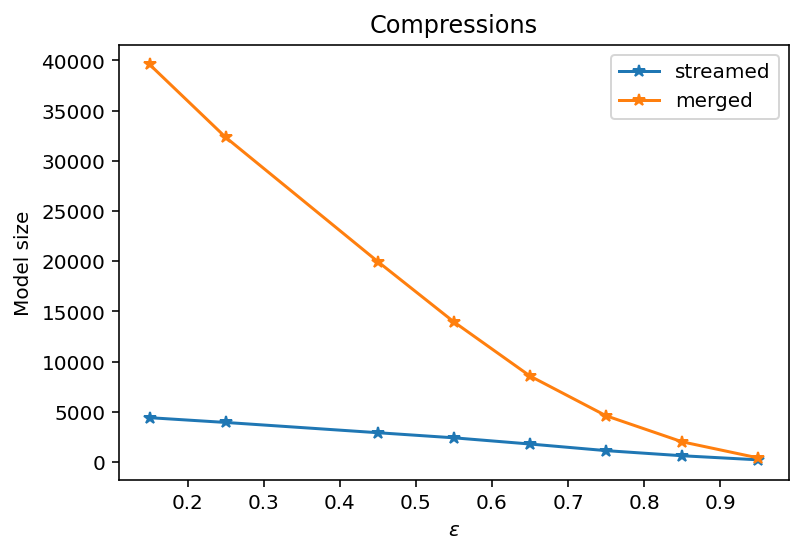

In [45]:
plt.title('Compressions')
plt.plot(sorted(streamed_nets.keys()), streamed_sizes,'-*', label='streamed');
plt.plot(sorted(merged_nets.keys()), merged_sizes,'-*', label='merged');

plt.legend()

plt.xlabel('$\epsilon$')

plt.ylabel('Model size');

In [75]:
f_size= 189452

def get_compression(sizes):
    return [1.0 - a/f_size for a in sizes]

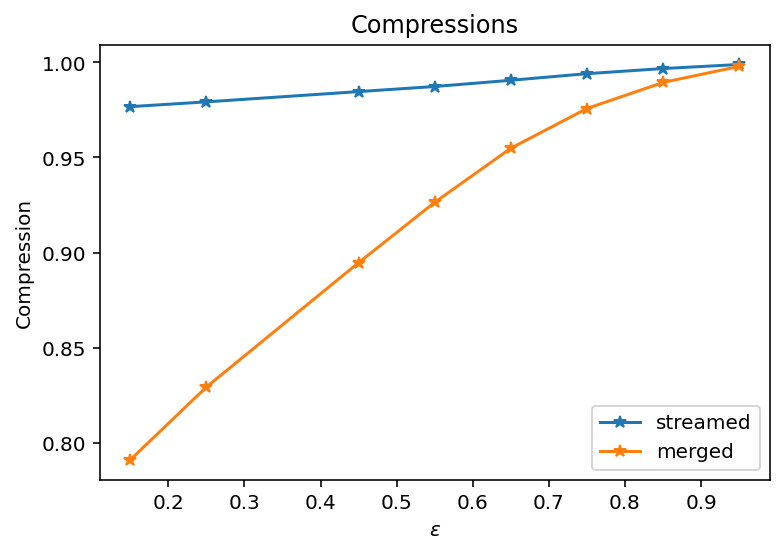

In [47]:
plt.title('Compressions')
plt.plot(sorted(streamed_nets.keys()), get_compression(streamed_sizes),'-*', label='streamed');
plt.plot(sorted(merged_nets.keys()), get_compression(merged_sizes),'-*', label='merged');

plt.legend()

plt.xlabel('$\epsilon$')
plt.ylabel('Compression');

In [48]:
labels = pd.read_csv('../res/newclusterres/apks_labels_hashed.csv', index_col=0)

def read_and_conv(fname, labels):
    with open(fname, 'rb') as f:
        eres = pickle.load(f)
    tblre = dict()
    for r, val in eres:
        tblre[r['apk']] = [r['nn'], val, not labels.loc[r['apk']]['malware_label']]
    return pd.DataFrame.from_dict(tblre, orient='index', columns=[ 'nearest', 'prob', 'true_val'])



In [49]:
def get_perf(directory, gammas):
    performance = dict()
    for gamma in gammas:
        df = read_and_conv(fname=f"{directory}/{gamma}-evalresults.pickle", labels=labels)
        [p1, r1, thresholds] = precision_recall_curve(df['true_val'], df['prob'])
        performance[gamma] = [p1, r1]
        
    return performance

In [84]:
#those are calcualted in a different way approximation threshold
del merged_nets[0.25] 
del merged_nets[0.45] 
del merged_nets[0.15]

In [50]:
perf_stream = get_perf(directory=stream_dir, gammas=streamed_nets.keys())
perf_merge = get_perf(directory=merged_dir, gammas=merged_nets.keys())

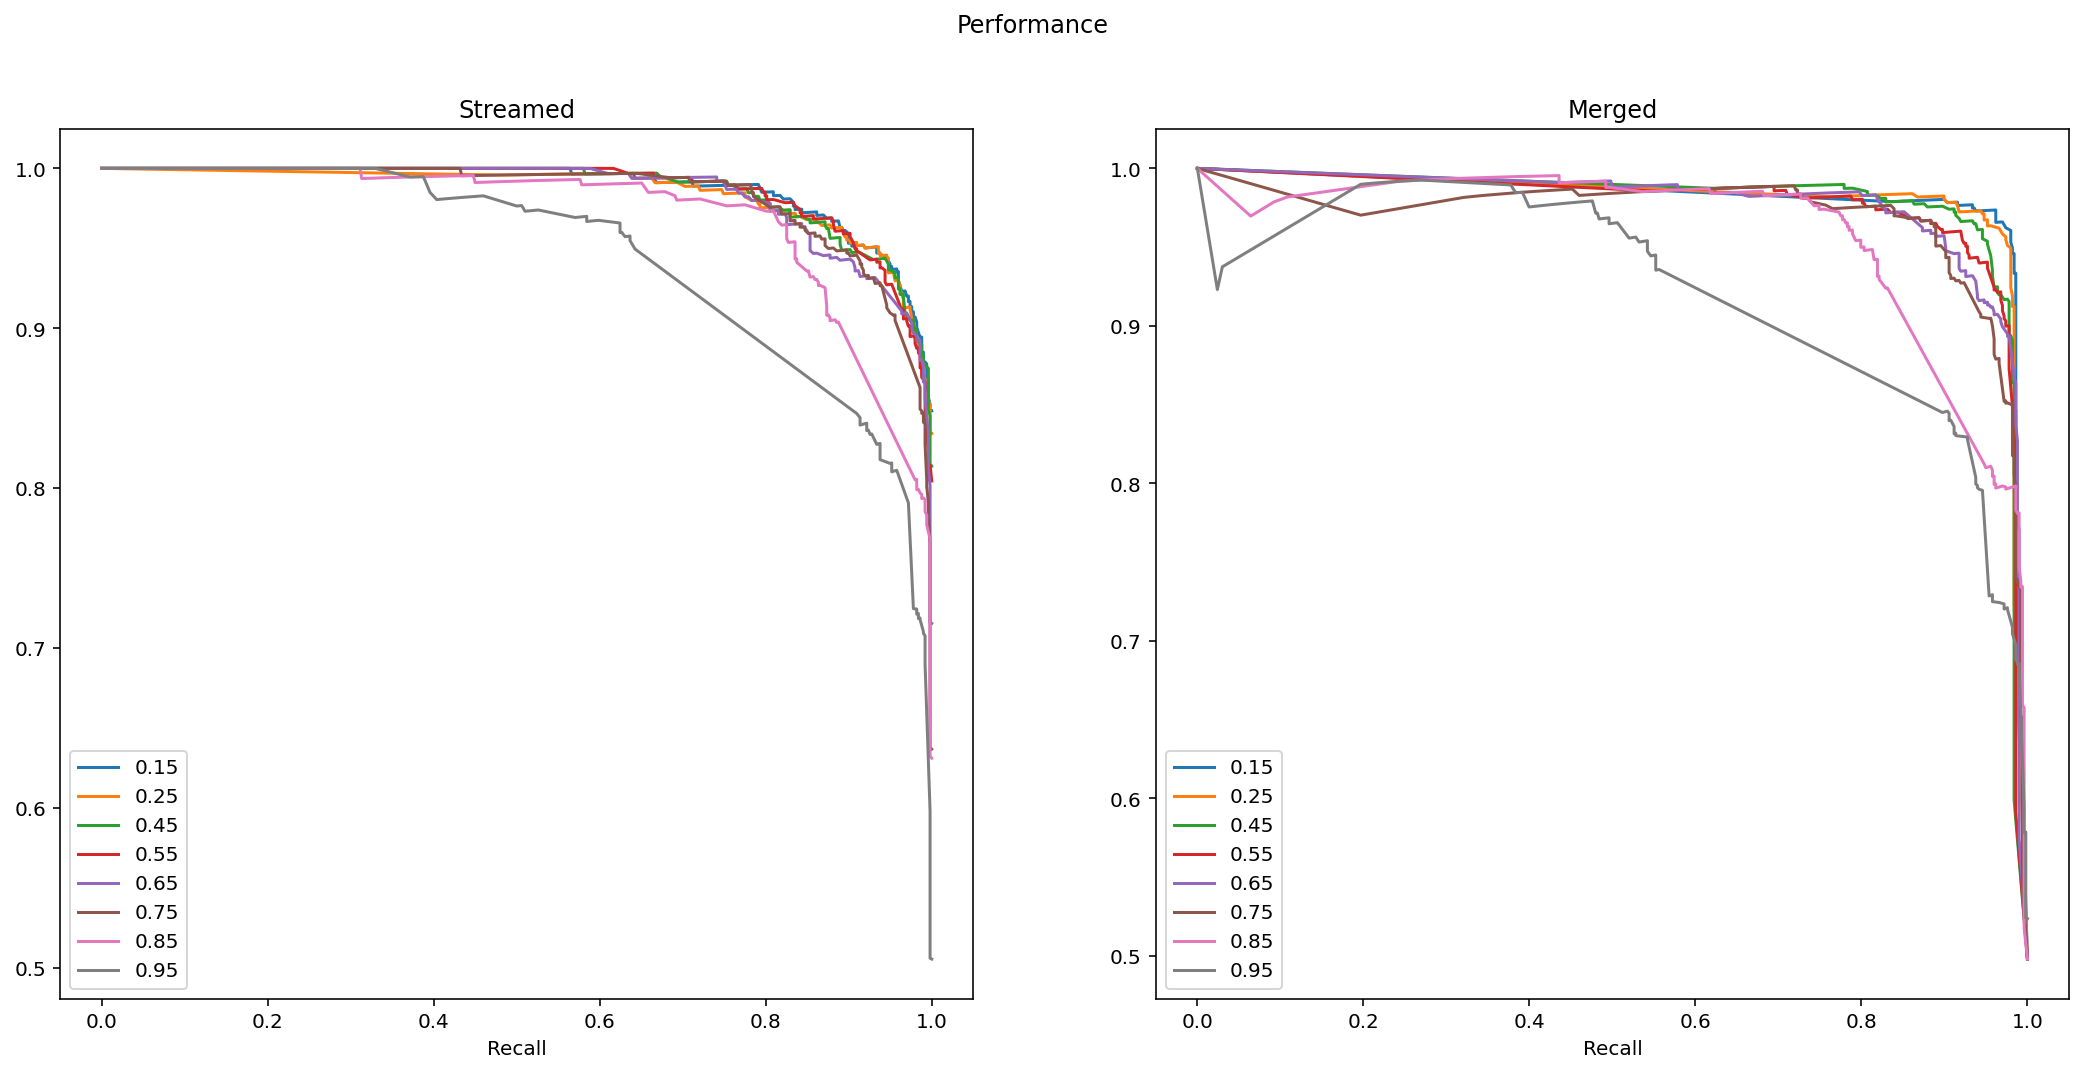

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))
fig.suptitle('Performance')

#plt.title('Performance of streamed network')
for gamma, [p1, r1] in sorted(perf_stream.items()):
    ax1.plot(r1, p1, label=f"{gamma}")
ax1.set_xlabel('Recall')
ax1.set_title('Streamed')
ax1.legend()
    
for gamma, [p1, r1] in sorted(perf_merge.items()):
    ax2.plot(r1, p1, label=f"{gamma}")
ax2.set_title('Merged')
ax2.set_xlabel('Recall')
ax2.legend();



In [52]:


def get_aucs(nets, perfs):
    return {1.0 - len(nets[gamma])/f_size: auc(r1, p1) for gamma, [p1, r1] in sorted(perfs.items())}

def get_eaucs(perfs):
    return {gamma: auc(r1, p1) for gamma, [p1, r1] in sorted(perfs.items())}


In [53]:
streamed_eaucs = get_eaucs(perfs=perf_stream)
merged_eaucs = get_eaucs(perfs=perf_merge)


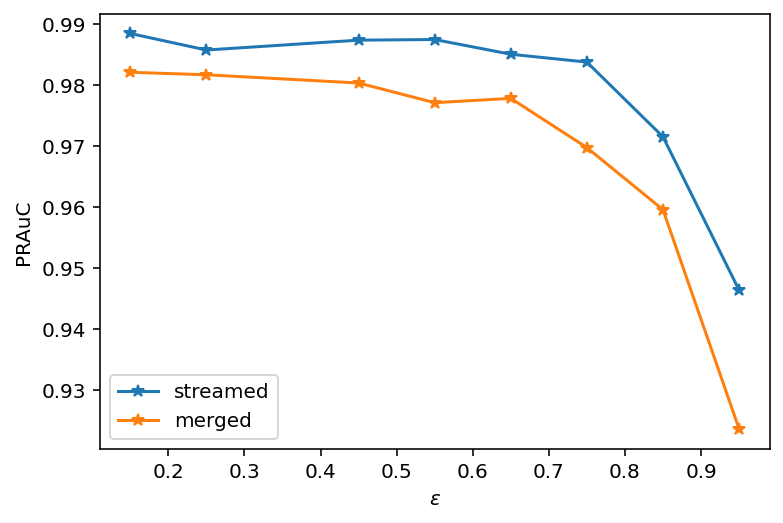

In [55]:
#plt.title('Model size vs. performance (streamed networks)')
plt.plot(streamed_eaucs.keys(), streamed_eaucs.values(),'-*',label='streamed')
plt.plot(merged_eaucs.keys(), merged_eaucs.values(), '-*', label='merged')

plt.xlabel("$\epsilon$")
plt.legend()
plt.ylabel('PRAuC');


In [56]:
#streamed_aucs = {len(streamed_nets[gamma]): auc(r1, p1) for gamma, [p1, r1] in sorted(perf_stream.items())}
#merged_aucs = {len(merged_nets[gamma]): auc(r1, p1) for gamma, [p1, r1] in sorted(perf_merge.items())}
streamed_aucs = get_aucs(nets=streamed_nets, perfs=perf_stream)
merged_aucs = get_aucs(nets=merged_nets, perfs=perf_merge)


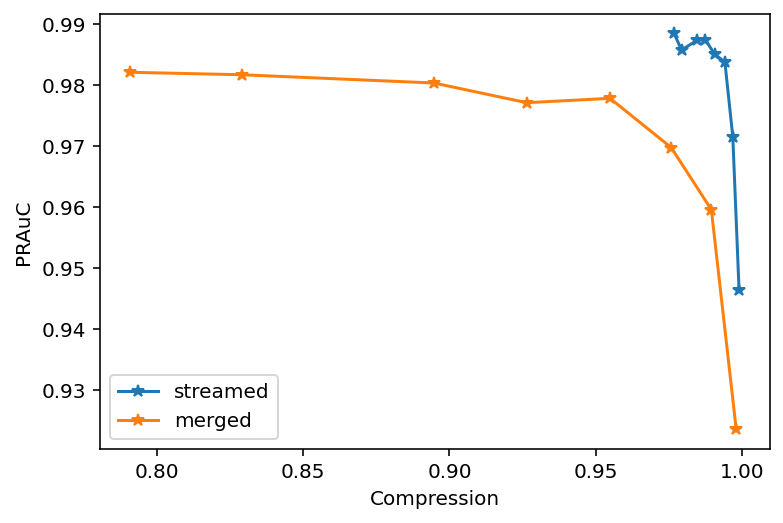

In [57]:
#plt.title('Model size vs. performance (streamed networks)')
plt.plot(streamed_aucs.keys(), streamed_aucs.values(),'-*',label='streamed')
plt.plot(merged_aucs.keys(), merged_aucs.values(),'-*', label='merged')


plt.xlabel('Compression')
plt.legend()
plt.ylabel('PRAuC');
plt.savefig('../fig/streammergefull.svg', format='svg', bbox_inches = 'tight', dpi=1000);

### subparts

In [87]:
all_parts = dict()
for perc in range(2,10,2):
    perc_dir = f"../res/newclusterres/cleans/subparts/{perc}/"
    netz, sizez = get_nets(directory=perc_dir)
    
    perfz = get_perf(directory=perc_dir, gammas=netz.keys())
    aucz = get_aucs(nets=netz, perfs=perfz) #{len(netz[gamma]): auc(r1, p1) for gamma, [p1, r1] in sorted(perfz.items())}
    all_parts[perc] = aucz
    print(perc, [(gamma, len(netz[gamma])) for gamma in sorted(netz.keys())])
    
print('x', [(gamma, len(streamed_nets[gamma])) for gamma in sorted(streamed_nets.keys())])

2 [(0.001, 1458), (0.002, 1445), (0.01, 1373), (0.11, 1243), (0.15, 1197), (0.25, 1110), (0.35, 1010), (0.45, 871), (0.55, 749), (0.65, 603), (0.75, 438), (0.85, 276), (0.95, 116)]
4 [(0.65, 996), (0.75, 677), (0.85, 409), (0.95, 155)]
6 [(0.65, 1295), (0.75, 856), (0.85, 491), (0.95, 179)]
8 [(0.65, 1558), (0.75, 1007), (0.85, 555), (0.95, 198)]
x [(0.15, 4406), (0.25, 3931), (0.45, 2909), (0.55, 2400), (0.65, 1782), (0.75, 1123), (0.85, 613), (0.95, 207)]


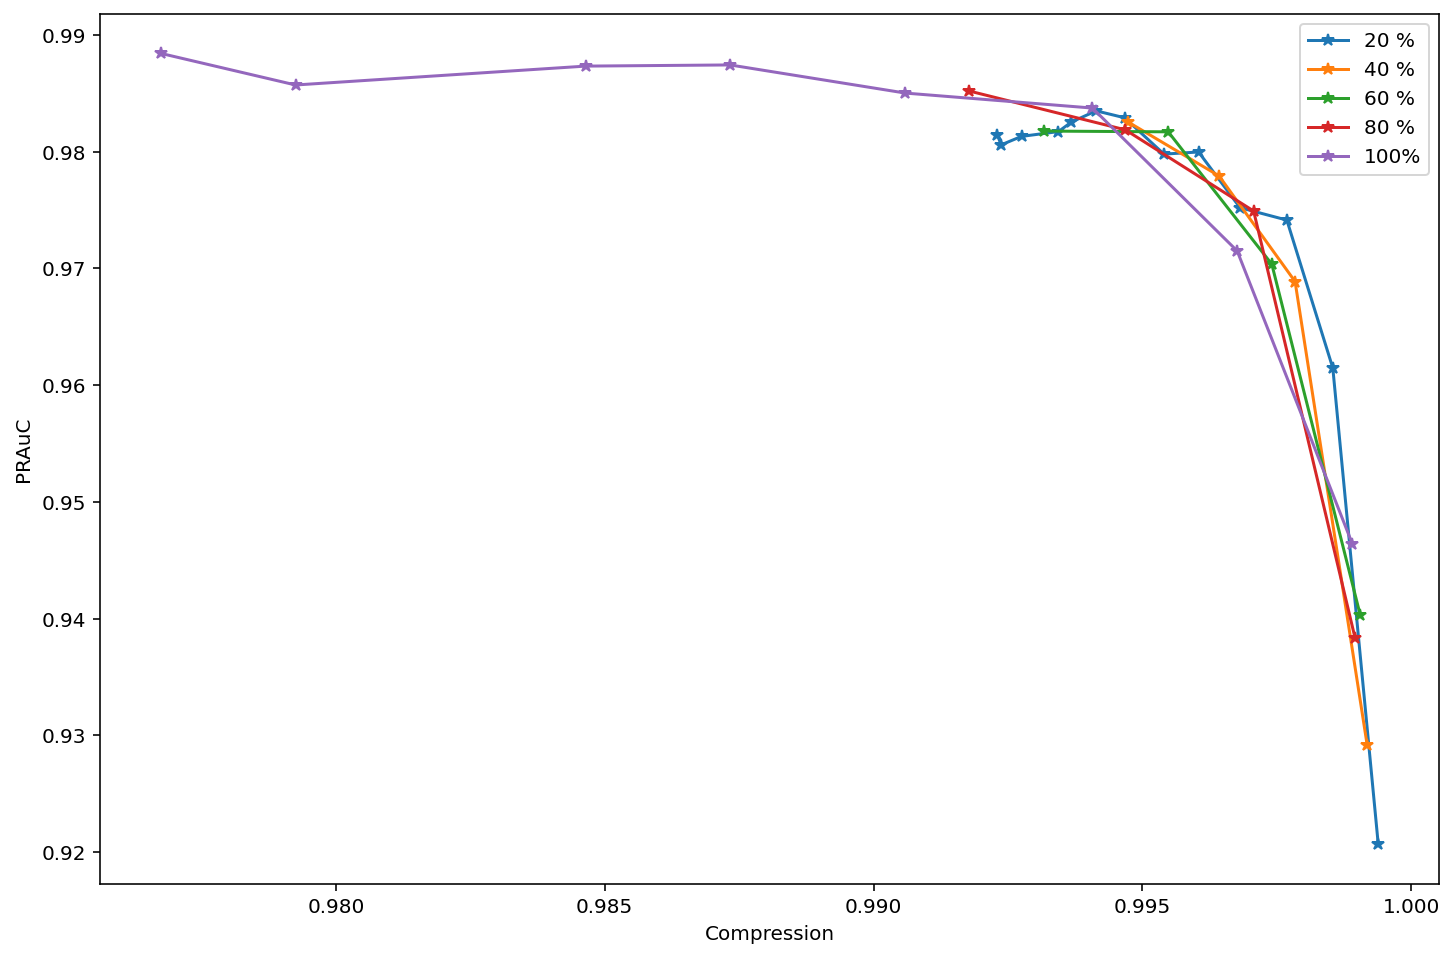

In [88]:
plt.figure(figsize=(12,8))
for perc,top in all_parts.items():
    plt.plot(top.keys(),top.values(),'-*', label=f"{perc*10} %")
    
plt.plot(streamed_aucs.keys(), streamed_aucs.values(),'-*', label='100%')


plt.xlabel('Compression')
plt.ylabel('PRAuC')
plt.legend();
#plt.savefig('../fig/subparts.svg', format='svg', bbox_inches = 'tight', dpi=1000);

In [63]:
all_parts[2].keys()

dict_keys([0.9936817769144691, 0.9941409961362245, 0.9946688343221503, 0.9954025294005869, 0.9960464919874163, 0.9968171357388679, 0.9976880687456453, 0.9985431666068451, 0.9993877077043262])

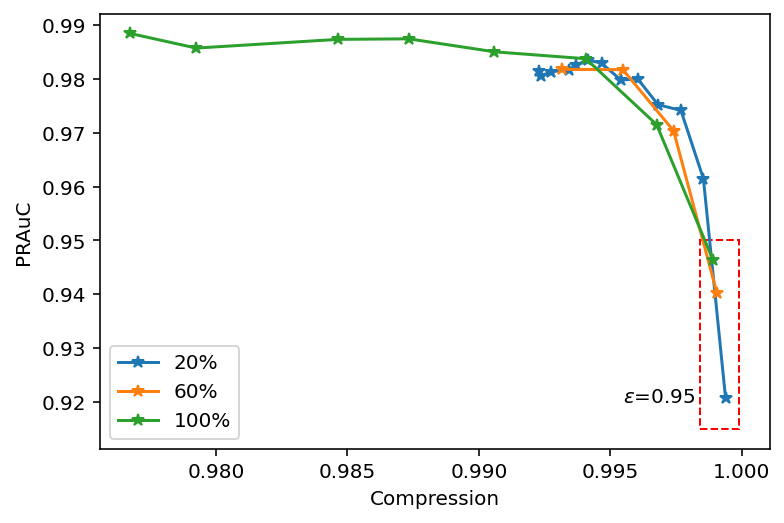

In [89]:
plt.plot(all_parts[2].keys(), all_parts[2].values(),'-*', label='20%')
plt.plot(all_parts[6].keys(), all_parts[6].values(),'-*', label='60%')
plt.plot(streamed_aucs.keys(), streamed_aucs.values(),'-*', label='100%')

plt.xlabel('Compression')
plt.ylabel('PRAuC')
plt.legend(loc=3);
plt.gca().add_patch(Rectangle((1.0-0.0016, 0.915), 0.0015, 0.035, edgecolor='red', fill=False, ls='--'))
plt.annotate('$\epsilon$=0.95', (1.0-0.0045, 0.92));
plt.savefig('../fig/subparts.svg', format='svg', bbox_inches = 'tight', dpi=1000);


## Random Subs
Random from 20% subpartition

In [65]:
! ls ../res/newclusterres/cleans/random-subs/

1010-evalresults.pickle             merged-116-0-tc-nets.pickle
1110-evalresults.pickle             merged-1197-0-tc-nets-voting.pickle
116-evalresults.pickle              merged-1197-0-tc-nets.pickle
1197-evalresults.pickle             merged-276-0-tc-nets-voting.pickle
276-evalresults.pickle              merged-276-0-tc-nets.pickle
438-evalresults.pickle              merged-438-0-tc-nets-voting.pickle
603-evalresults.pickle              merged-438-0-tc-nets.pickle
749-evalresults.pickle              merged-603-0-tc-nets-voting.pickle
871-evalresults.pickle              merged-603-0-tc-nets.pickle
merged-1010-0-tc-nets-voting.pickle merged-749-0-tc-nets-voting.pickle
merged-1010-0-tc-nets.pickle        merged-749-0-tc-nets.pickle
merged-1110-0-tc-nets-voting.pickle merged-871-0-tc-nets-voting.pickle
merged-1110-0-tc-nets.pickle        merged-871-0-tc-nets.pickle
merged-116-0-tc-nets-voting.pickle


In [92]:
randomsubs_dir = '../res/newclusterres/cleans/random-subs/'
randomfull_dir = '../res/newclusterres/cleans/fullran/'

rands_nets, rands_sizes = get_nets(directory=randomsubs_dir, convert=False)
rands_perf = get_perf(directory=randomsubs_dir, gammas=rands_nets.keys())
rands_aucs = get_aucs(nets=rands_nets, perfs=rands_perf) #{len(rand_nets[gamma]): auc(r1, p1) for gamma, [p1, r1] in sorted(rand_perf.items())}

frand_nets, frand_sizes = get_nets(directory=randomfull_dir, convert=False)
frand_perf = get_perf(directory=randomfull_dir, gammas=frand_nets.keys())
frand_aucs = get_aucs(nets=frand_nets, perfs=frand_perf)

In [83]:
for g, n in rands_nets.items():
    print( len(n))

116
276
437
602
745
869
1008
1110
1194


In [97]:
sorted(streamed_sizes), sorted(frand_sizes)

([207, 613, 1123, 1782, 2400, 2909, 3931, 4406], [1777, 2389, 2897, 3911])

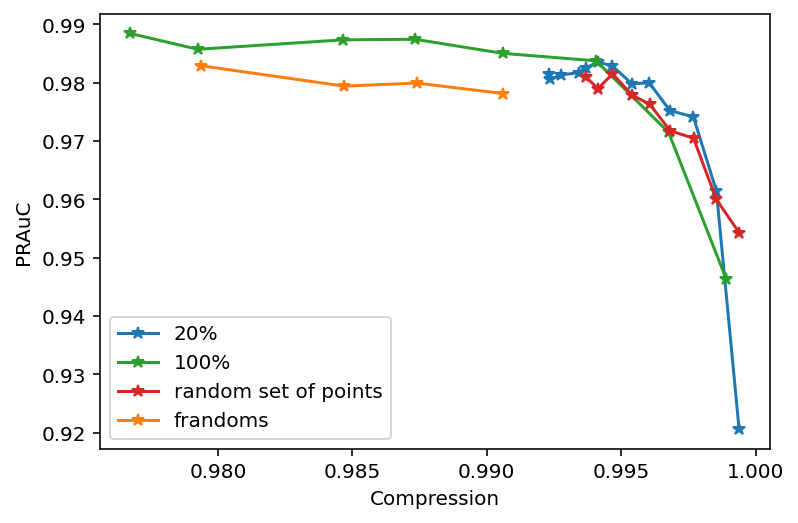

In [93]:
plt.plot(all_parts[2].keys(), all_parts[2].values(),'-*', label='20%')
plt.plot(streamed_aucs.keys(), streamed_aucs.values(),'-*', label='100%',c='#2ca02c')
plt.plot(rands_aucs.keys(), rands_aucs.values(), '-*', label='random set of points',c='#d62728')
plt.plot(frand_aucs.keys(), frand_aucs.values(), '-*', label='frandoms')
#plt.plot(rand_aucs.keys(), rand_aucs.values(), '-*', label='randoms')


plt.xlabel('Compression')
#plt.xlim([0.990, 1.000])
plt.ylabel('PRAuC')
plt.legend();
plt.savefig('../fig/randoms.svg', format='svg', bbox_inches = 'tight', dpi=1000);

In [55]:
## more on 20%
perc_dir = f"../res/newclusterres/cleans/subparts/2/"
netz, sizez = get_nets(directory=perc_dir)
    
perfz = get_perf(directory=perc_dir, gammas=netz.keys())
aucz = get_aucs(nets=netz, perfs=perfz) #{len(netz[gamma]): auc(r1, p1) for gamma, [p1, r1] in sorted(perfz.items())}


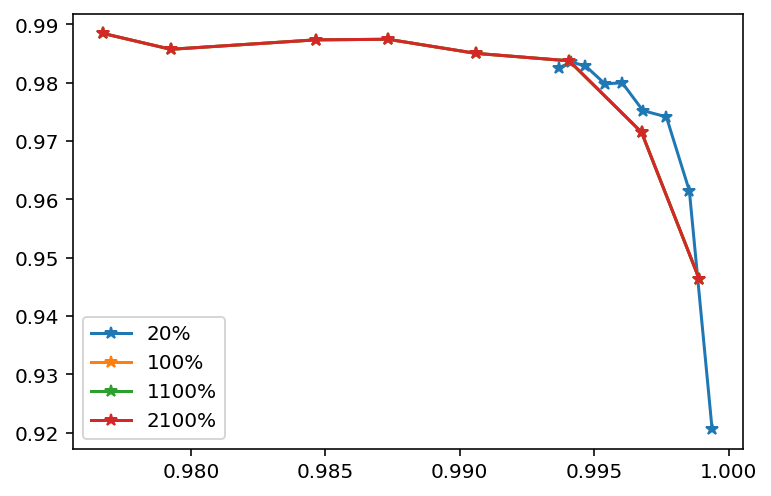

In [75]:
plt.plot(aucz.keys(), aucz.values(),'-*', label='20%')
plt.plot(streamed_aucs.keys(), streamed_aucs.values(),'-*', label='100%')
m=plt.plot(streamed_aucs.keys(), streamed_aucs.values(),'-*', label='1100%')
plt.plot(streamed_aucs.keys(), streamed_aucs.values(),'-*', label='2100%')
plt.legend();

In [33]:
sizez

[1010, 871, 749, 603, 438, 276, 116]

## Compression bounds

```
Loading /Users/jj/git/knnexp/data/test-tc-0.2
data size, unique apks, all apks
(23885587, 2) (1484,) (2356,)
```

Number of apks in 20% partition -> 2356 from that 1484 are unique 

In [77]:
get_compression([1484]), all_parts[2].keys()

([0.9921668813208623],
 dict_keys([0.9936817769144691, 0.9941409961362245, 0.9946688343221503, 0.9954025294005869, 0.9960464919874163, 0.9968171357388679, 0.9976880687456453, 0.9985431666068451, 0.9993877077043262]))

Sizes of 20% networks 
```
(0.001 --> 1458), (0.002--> 1445) (0.01 --> 1373), (0.11--> 1243), (0.15--> 1197), (0.25--> 1110)
```


Full first partition:

```
Loading /storage/users/cnalab/apkdata-tanya/binary/part-0/
data size, unique apks, all apks
(120871501, 2) (6046,) (11779,)
```

In [79]:
get_compression([6046]), streamed_aucs.keys()

([0.9680869032789308],
 dict_keys([0.9767434495281127, 0.9792506809112599, 0.9846451871714207, 0.9873318835377827, 0.9905939235268036, 0.9940723771720541, 0.9967643519202753, 0.9989073749551337]))